In [80]:
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics

In [84]:
it_df = pd.read_csv('data/train_events1.csv', sep=';')
X = it_df['description'].to_numpy()
y = it_df['class'].to_numpy()

x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [155]:
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, max_features=20)
X_train = vectorizer.fit_transform(x_train)

In [156]:
feature_names = np.array(vectorizer.get_feature_names())

target_names = [['ds'],['gamedev'], ['mobile'],['qa'], ['web']]

In [157]:
feature_names

array(['встреча', 'выступить', 'год', 'ждать', 'использование',
       'количество', 'компания', 'место', 'мобильный', 'новый', 'опыт',
       'приложение', 'проект', 'работа', 'работать', 'рассмотреть',
       'спикер', 'тестирование', 'технология', 'язык'], dtype='<U13')

In [158]:
X_test = vectorizer.transform(x_test)

In [159]:
def trim(s):
    return s if len(s) <= 80 else s[:77] + "..."

In [160]:
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

        if feature_names is not None:
            print("top 10 keywords per class:")
            for i, label in enumerate(target_names):
                top10 = np.argsort(clf.coef_[i])[-10:]
                print(trim("%s: %s" % (label, " ".join(feature_names[top10]))))
        print()


    print("confusion matrix:")
    print(metrics.confusion_matrix(y_test, pred))
    

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time


results = []
for clf, name in (
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(), "Random forest")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))



print('=' * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))
results.append(benchmark(ComplementNB(alpha=.1)))

kNN
________________________________________________________________________________
Training: 
KNeighborsClassifier(n_neighbors=10)
train time: 0.000s
test time:  0.001s
accuracy:   0.500
confusion matrix:
[[0 0 2 0 0]
 [0 0 1 0 0]
 [0 0 3 0 0]
 [0 0 0 1 0]
 [0 1 0 0 0]]

Random forest
________________________________________________________________________________
Training: 
RandomForestClassifier()
train time: 0.082s
test time:  0.006s
accuracy:   0.500
confusion matrix:
[[0 0 2 0 0]
 [0 0 1 0 0]
 [0 0 3 0 0]
 [0 0 0 1 0]
 [0 1 0 0 0]]

Naive Bayes
________________________________________________________________________________
Training: 
MultinomialNB(alpha=0.01)
train time: 0.001s
test time:  0.000s
accuracy:   0.375
dimensionality: 20
density: 1.000000
top 10 keywords per class:
['ds']: проект количество место мобильный компания использование выступить вс...
['gamedev']: количество использование ждать год место проект рассмотреть рабо...
['mobile']: работа работать рассмотреть ко

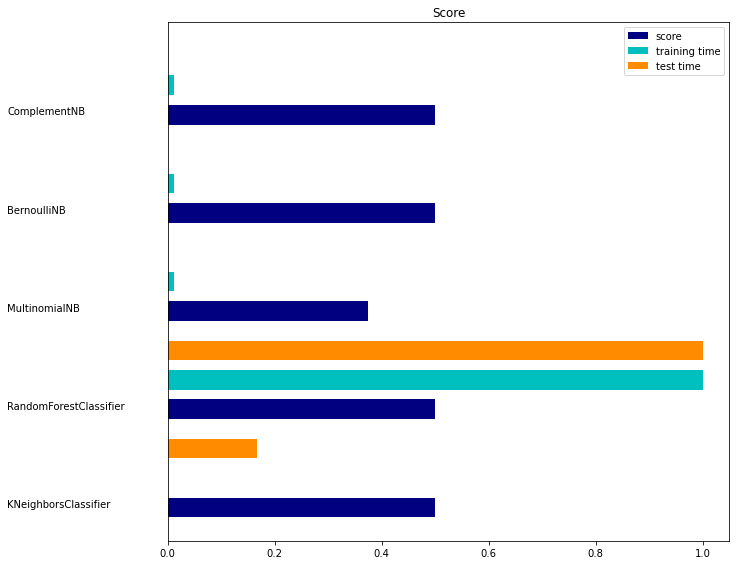

In [161]:
indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()

In [162]:
from sklearn.model_selection import cross_val_score

mdl = MultinomialNB(alpha=.01)
scores = cross_val_score(mdl, X_train, y_train, cv=2)
scores

array([0.6       , 0.64285714])

In [163]:
mdl = BernoulliNB(alpha=.01)
scores = cross_val_score(mdl, X_train, y_train, cv=2)
scores

array([0.46666667, 0.57142857])

In [164]:
mdl = ComplementNB(alpha=.1)
scores = cross_val_score(mdl, X_train, y_train, cv=2)
scores

array([0.6       , 0.57142857])

In [168]:
mdl = KNeighborsClassifier(n_neighbors=10)
scores = cross_val_score(mdl, X_train, y_train, cv=2)
scores

array([0.46666667, 0.5       ])

In [166]:
mdl = RandomForestClassifier()
scores = cross_val_score(mdl, X_train, y_train, cv=2)
scores

array([0.6       , 0.64285714])